In [0]:
#!pip install torch torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import datasets, transforms
import seaborn as sns
sns.set()
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(x_test.shape)

Using TensorFlow backend.


(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000, 28, 28)


In [0]:
class Net(nn.Module):
  ## constructor
  def __init__(self):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(28*28, 50)  ## linear model
    self.fc1_drop = nn.Dropout(0.2)  ## dropout column 20  %
    self.fc2 = nn.Linear(50, 50)     ## linear previous and after 50,50
    self.fc2_drop = nn.Dropout(0.2)
    self.fc3 = nn.Linear(50, 10)     ## final layer
    
    ## this is the layer information
    
  def forward(self,x):
    # adding functionality
    x = x.view(-1,28*28)
    ## adding the rectified linear to the layer 1
    x=F.relu(self.fc1(x))  ## ading the value to x to the layer and then apply relu
    x=self.fc1_drop(x)
    x=F.relu(self.fc2(x))
    x =self.fc2_drop(x)
    return F.log_softmax(self.fc3(x),dim=1)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.1.0  Device: cuda


In [0]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)


Using PyTorch version: 1.1.0  Device: cuda


In [0]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)


In [8]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


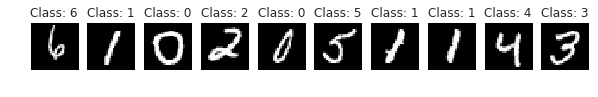

In [9]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i].item()))

In [0]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [0]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [12]:
%%time
epochs = 5

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326291
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.095009
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.380959
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.881740
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.690922
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.582633
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.530609
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.463946
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.466501
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.456487

Validation set: Average loss: 0.3620, Accuracy: 9002/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.808021
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.621670
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.275245
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.368286
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.484802
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.615639
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.247310
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.716126
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.36